# Guided Test Case Generation System Notebook

In [6]:
# Basic libraries
import os, sys
import numpy as np
import re
import string
from datetime import datetime
import math
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Speech
import soundfile as sf # pip install pysoundfile
import python_speech_features as speech_lib # pip install python_speech_features


# Machine learning
import nltk
import xgboost
from sklearn.utils import shuffle
from sklearn.base import clone as clone_model
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import joblib

import tensorflow as tf


%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [14]:
def read_data(fpath) :
    df = pd.read_csv(fpath, sep=",", header=None)
    df.columns = ["sentence", "label"]
    return df

df = {
    "deepspeech": read_data("training_data/deepspeech.txt"),
    "paddledeepspeech" : read_data("training_data/paddledeepspeech.txt"),
    "wav2letter": read_data("training_data/wav2letter.txt"),
    "wit": read_data("training_data/wit.txt")
}

# shuffle data
# for key in df.keys() :
#     df[key] = df[key].sample(frac=1).reset_index(drop=True)

corpus_filepath = "corpus-sentence.txt"

BUG_LABEL = 1
NON_BUG_LABEL = 0
UNDETERMINED_LABEL = -1

In [15]:
df["deepspeech"].head()

,sentence,label
0,had laid before her a pair of alternatives now...,-1
1,property erects a kind of barrier you can do a...,-1
2,i mean of course if you'll take a companion so...,-1
3,she'd keep people off very well i think,1
4,that it's a great deal better you should remai...,1


In [16]:
# intersection between two sets
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

bugs = []
for key in df.keys() :
    index = np.where(df[key]["label"] == BUG_LABEL)
    bugs.append(index[0])
    
non_bugs = []
for key in df.keys() :
    index = np.where(df[key]["label"] == NON_BUG_LABEL)
    non_bugs.append(index[0])

In [17]:
success_test_case = non_bugs[0]

for i in range(1, len(non_bugs)) :
#     print("success test case: " + str(success_test_case))
#     print(i)
    success_test_case = intersection(success_test_case, non_bugs[i])

undetermined_test_case = np.where(df["deepspeech"]["label"] == UNDETERMINED_LABEL)[0]

print("number of success test case: " + str(len(success_test_case)))
print("number of undetermined test case: " + str(len(undetermined_test_case)))
number_of_fail_test_case = len(df["deepspeech"]["label"]) - len(success_test_case) - len(undetermined_test_case)
print("number of fail test case: " + str(number_of_fail_test_case))

number of success test case: 113
number of undetermined test case: 20966
number of fail test case: 7460


### Data distribution





deepspeech


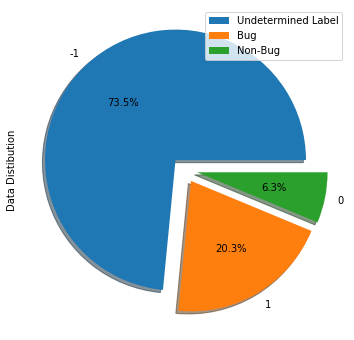





paddledeepspeech


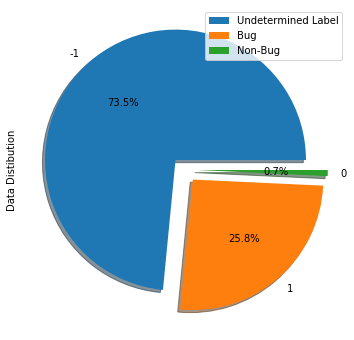





wav2letter


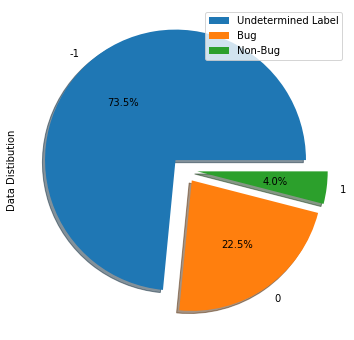





wit


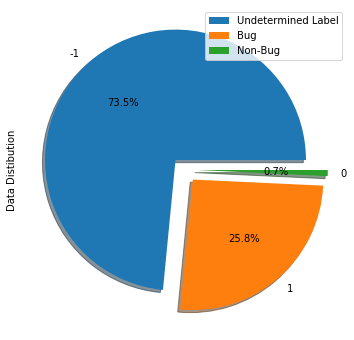

In [18]:
for key in df.keys() :
    print("\n\n\n")
    print(key)
    # print(df[key].groupby("label").describe())
    df[key]["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
    plt.ylabel("Data Distibution")
    plt.legend(["Undetermined Label", "Bug", "Non-Bug"])
    plt.show()

we need to handle imbalance data

### Handle Imbalance Data

Upsample the small data

Resample Size: 7362


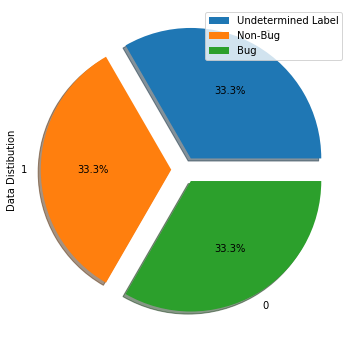

In [5]:
def upsampleMinority(df):
    # Separate majority and minority classes
    df_majority = df[df.label==NON_BUG_LABEL]
    df_minority = df[df.label==BUG_LABEL]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    return df_upsampled.copy()

def downsampleMajority(df) :
    # Separate majority and minority classes
    df_majority = df[df.label==NON_BUG_LABEL]
    df_minority = df[df.label==BUG_LABEL]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_minority),    # to match minority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_resampled = pd.concat([df_majority_downsampled, df_minority])

    return df_resampled.copy()

def resampleToFixNumber(df, n):
    # Separate majority and minority classes
    df_non_bug = df[df.label==NON_BUG_LABEL]
    df_bug = df[df.label==BUG_LABEL]
    df_undetermined = df[df.label==UNDETERMINED_LABEL]

    df_non_bug = resample(df_non_bug, 
                     replace=True,     # sample with replacement
                     n_samples=n,    # to match minority class
                     random_state=123) # reproducible results
    
    df_bug = resample(df_bug, 
                     replace=True,     # sample with replacement
                     n_samples=n,    # to match majority class
                     random_state=123) # reproducible results
    
    df_undetermined = resample(df_undetermined, 
                     replace=True,     # sample with replacement
                     n_samples=n,    # to match majority class
                     random_state=123) # reproducible results

    
    # Combine majority class with upsampled minority class
    df_resampled = pd.concat([df_undetermined, df_bug, df_non_bug])

    return df_resampled.copy()

def getResampleSize(df) :
    size = 0
    for k in df.keys() :
        df_bug = df[k][df[k].label==BUG_LABEL]
        if (len(df_bug["label"]) > size) :
            size = len(df_bug["label"])
    
    return size

RESAMPLE_SIZE = getResampleSize(df)
print("Resample Size: %d" % RESAMPLE_SIZE)

sample = resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
sample["label"].value_counts().plot(kind = 'pie', explode = [0.1, 0.1, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Data Distibution")
plt.legend(["Undetermined Label", "Non-Bug", "Bug"])
plt.show()

### Feature Extraction

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import string

def remove_punctuation(sentence) :
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Text processing: remove punction
def text_process(sentence):
    nopunc =[char for char in sentence if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split()]

In [7]:
NUM_CORES = 4
EMBEDDING_SIZE = 13

In [8]:
from gensim.models import Word2Vec

corpus_sentence = pd.read_csv('corpus-sentence.txt', sep=",", header=None)
corpus_sentence.columns = ["sentence"]
tokenized_corpus = list(corpus_sentence['sentence'].apply(text_process))

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    size=EMBEDDING_SIZE,
    min_count=1,
    window=5,
    workers=NUM_CORES,
    seed=1337
)

w2v_model.save("model/word2vec.model")

# Show that similar words to 'program' print
# w2v_model.wv.most_similar(positive='program')

# Encode the documents using the new embedding
encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_corpus]

### Length variation on each sentence

In [9]:
print(len(encoded_docs[0]))
print(len(encoded_docs[1])) 
# print(encoded_docs[0]) 

42
40


In [10]:
def max_length_sentence_from_corpus(encoded_docs):
    max = 0
    for encoded_sentence in encoded_docs :
        if (len(encoded_sentence) > max) :
            max = len(encoded_sentence)
    return max


MAX_LENGTH = max_length_sentence_from_corpus(encoded_docs)
MAX_LENGTH

75

In [11]:
# because the length of each sentence is various 
# and we use non-sequential machine learning model
# we need to make padding for each sentences
def create_padding_on_sentence(encoded_docs) :
    padded_posts = []

    for post in encoded_docs:

        # Pad short posts with alternating min/max
        if len(post) < MAX_LENGTH:

            padding_size = MAX_LENGTH - len(post)

            for _ in range(0, padding_size) :
                post.append(np.zeros((EMBEDDING_SIZE)))


        # Shorten long posts or those odd number length posts we padded to MAX_LENGTH
        if len(post) > MAX_LENGTH:
            post = post[:MAX_LENGTH]

        # Add the post to our new list of padded posts
        padded_posts.append(post)
    
    return padded_posts

In [12]:
def flatten_docs(padded_docs) :
    flatten = []
    for sentence in padded_docs:
        ps = []
        for word in sentence :
            for feature in word :
                ps.append(feature)
        flatten.append(ps)
    return np.asarray(flatten)

In [13]:
temp_data = resampleToFixNumber(df["deepspeech"], RESAMPLE_SIZE)
temp_data = shuffle(temp_data)
temp_data = temp_data.reset_index(drop=True)

In [14]:
temp_data.head()

,sentence,label
0,you cannot tell a man by the lobster he eats b...,1
1,uncle roger unlocked and flung open the front ...,1
2,and two and twenty thousand horsemen besides t...,1
3,after a couple of minutes unbroken silence hen...,-1
4,his cousin was a very brilliant girl,0


In [15]:
def extract_feature(docs) :
    tokenized_sentences = docs.apply(text_process)
    encoded_docs = [[w2v_model.wv[word] for word in sentence] for sentence in tokenized_sentences]
    padded_docs = create_padding_on_sentence(encoded_docs)
    flatten_array = flatten_docs(padded_docs)
    return flatten_array

In [16]:
temp_data["sentence"][0]

'you cannot tell a man by the lobster he eats but you can tell something about him by the literature he reads for instance i once occupied a carriage on an eastern line'

In [17]:
flatten_array = extract_feature(temp_data['sentence'])

In [18]:
# flatten_array[0]

In [19]:
# https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

import scikitplot.metrics as skplt

def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = RandomForestClassifier(n_estimators=31, random_state=111)

    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8,shuffle=True), n_jobs=4, method='predict_proba', verbose=2)
#     print(probas)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.5s finished


Log loss: 0.417494293516595
Accuracy: 0.84773159467536


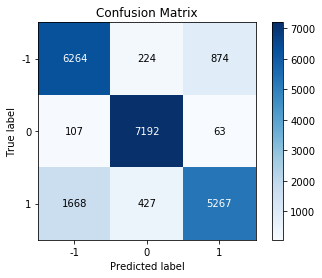

In [20]:
evaluate_features(flatten_array, temp_data["label"])

## Experiment

### Trying Model in the First Batch

In [21]:
N_JOBS = 4

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=10)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='lbfgs', n_jobs=N_JOBS)
rfc = RandomForestClassifier(n_estimators=31, random_state=111, n_jobs=N_JOBS)
abc = AdaBoostClassifier(n_estimators=31, random_state=111)
bc = BaggingClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
etc = ExtraTreesClassifier(n_estimators=10, random_state=111, n_jobs=N_JOBS)
xgb = xgboost.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

In [22]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc, 'XGB': xgb }

In [23]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return clf.predict(features)

# intersection between 2 sets
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [29]:
k = list(df.keys())[0]
FIRST_BATCH_SIZE = math.ceil(len(df[k]["label"]) * 3 / 4 )
# FIRST_BATCH_SIZE = math.ceil(len(df[k]["label"]) / 2 )
BATCH_SIZE = math.ceil(len(df[k]["label"]) / 2 / 3)
MAX_SIZE = len(df[k]["label"])

features = {}
labels = {}
for k,v in df.items() :
    data = v[:FIRST_BATCH_SIZE]
    data = resampleToFixNumber(data, RESAMPLE_SIZE)
    features[k] = extract_feature(data["sentence"])
    labels[k] = data["label"]

In [30]:
models = {}
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "RF", "AdaBoost", "BgC", "ETC", "XGB"]
# selected_clfs = ["SVC", "KN", "NB", "DT", "LR", "AdaBoost", "XGB"]
# selected_clfs = ["RF"]
selected_clfs = ["KN", "DT", "LR", "RF", "AdaBoost", "ETC"]
for k in selected_clfs :
    per_sr_model = {}
    for key_sr in features.keys() :
        model = None
        model = clone_model(clfs[k])
        train_classifier(model, features[key_sr], labels[key_sr])
        per_sr_model[key_sr] = model
    models[k] = per_sr_model
    
for clf in models.keys() :
    for sr in models[clf].keys():
        filename = "model/" + clf + "_" + sr + ".sav"
        joblib.dump(models[clf][sr], filename)

### Trying Model for the Next Batch until Finish

In [31]:
performance_writer = open(
        "performance/word2vec_" + str(datetime.now()) + ".txt", "w+")


for key_clf, v in models.items() :
    # classify the selected data
    training_data = {}
    for key_sr, model in v.items():
        training_data[key_sr] = df[key_sr][:FIRST_BATCH_SIZE]

    lower_bound = FIRST_BATCH_SIZE

    columns = ["Predicted", "CorrectlyPredictedBug", "UndetectedBug", "Precision", "Recall", "F1"]
    index = []
    performance_data = []

    while (lower_bound < MAX_SIZE) :
        # set the upper bound size
        upper_bound = lower_bound + BATCH_SIZE
        if (upper_bound > MAX_SIZE) :
            upper_bound = MAX_SIZE
        batch = str(lower_bound) + " - " + str(upper_bound)
        index.append(batch)
            
        union_used_index = []
        union_bug_index = []
        bug_index_per_model = {}
            
        for key_sr, model in v.items():
            # get the data to be selected
            current_data = df[key_sr][lower_bound:upper_bound]
            current_sentence = current_data["sentence"]
            current_labels = current_data["label"]

            # extract feature from the data
            current_features = extract_feature(current_sentence)

            # predict the current data
            pred = predict_labels(model, current_features)

            # see the classifier performance
            used_index = np.where(pred == BUG_LABEL)
            bug_index = np.where(current_labels == BUG_LABEL)
            
            union_used_index = list(set().union(union_used_index, used_index[0]))
            union_bug_index = list(set().union(union_bug_index, bug_index[0]))
            bug_index_per_model[key_sr] = bug_index[0]
            

        intersect = intersection(union_used_index, union_bug_index)
        intersection_length = len(intersect)
        undetected_bug = len(union_bug_index)-intersection_length
        precision = 0
        if (len(union_used_index) != 0) :
            precision = round(intersection_length/len(union_used_index), 2)
        recall = 0
        if ((intersection_length + undetected_bug) != 0) :
            recall = round(intersection_length/(intersection_length + undetected_bug), 2)
        precision_recall = precision + recall
        f1 = 0
        if precision_recall != 0 :
            f1 = round( 2 * precision * recall / (precision_recall), 2)
        performance_data.append([len(union_used_index), intersection_length, undetected_bug, precision, recall, f1])
        
        # add the predicted data to previous data
        if (len(union_used_index) > 0) :
            for key_sr, bug_index in bug_index_per_model.items() :
                intersection_index = intersection(union_used_index, bug_index)
                added_data = current_data.iloc[intersection_index,:]
                training_data[key_sr].append(added_data)
                
                # handle imbalance data
                resampled_data = resampleToFixNumber(training_data[key_sr], RESAMPLE_SIZE)

                # re-extract feature
                features[key_sr] = extract_feature(resampled_data["sentence"])
                labels[key_sr] = resampled_data["label"]

                # re-train the model 
                train_classifier(model, features[key_sr], labels[key_sr])

        # update the lower bound
        lower_bound = upper_bound

    performance = pd.DataFrame(performance_data, index=index, columns=columns)
    print("Classifier: " + key_clf) 
    print(performance)
    generated = int(performance["Predicted"].sum(axis=0))
    correctly_predicted_bug = int(performance["CorrectlyPredictedBug"].sum(axis=0))
    undetected_bug =  int(performance["UndetectedBug"].sum(axis=0))
    precision = round(performance["Precision"].mean(), 2)
    recall = round(performance["Recall"].mean(), 2)
    f1 = round(performance["F1"].mean(), 2)
    print("Total Generated: %d" % (generated))
    print("Correctly Predicted Bug: %d" % (correctly_predicted_bug))
    print("Undetected Bug: %d" % (undetected_bug))
    print("Total bug: %d" % (correctly_predicted_bug + undetected_bug) )
    print("Precision: %.2f" % (precision))
    print("Recall: %.2f" % (recall))
    print("F1: %.2f" % (f1))
    print("\n")
    
    performance_writer.write("Classifier: %s" % (key_clf))
    performance_writer.write("\n" + str(performance))
    performance_writer.write("\nTotal Generated: %d" % (generated))
    performance_writer.write("\nCorrectly Predicted Bug: %d" % (correctly_predicted_bug))
    performance_writer.write("\nUndetected Bug: %d" % (undetected_bug))
    performance_writer.write("\nTotal bug: %d" % (correctly_predicted_bug + undetected_bug) )
    performance_writer.write("\nPrecision: %.2f" % (precision))
    performance_writer.write("\nRecall: %.2f" % (recall))
    performance_writer.write("\nF1: %.2f" % (f1))
    performance_writer.write("\n\n")

performance_writer.close()

Classifier: KN
               Predicted  CorrectlyPredictedBug  UndetectedBug  Precision  \
21405 - 26162       4102                   2380            380       0.58   
26162 - 28539       2017                   1148            204       0.57   

               Recall    F1  
21405 - 26162    0.86  0.69  
26162 - 28539    0.85  0.68  
Total Generated: 6119
Correctly Predicted Bug: 3528
Undetected Bug: 584
Total bug: 4112
Precision: 0.57
Recall: 0.86
F1: 0.68


Classifier: DT
               Predicted  CorrectlyPredictedBug  UndetectedBug  Precision  \
21405 - 26162       3603                   2133            627       0.59   
26162 - 28539       1817                   1070            282       0.59   

               Recall    F1  
21405 - 26162    0.77  0.67  
26162 - 28539    0.79  0.68  
Total Generated: 5420
Correctly Predicted Bug: 3203
Undetected Bug: 909
Total bug: 4112
Precision: 0.59
Recall: 0.78
F1: 0.68


Classifier: LR
               Predicted  CorrectlyPredictedBug  Undete